In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.xception import Xception
from keras import metrics

In [2]:
# from tensorflow.keras.mixed_precision import experimental as mixed_precision
from tensorflow.python.keras.mixed_precision.policy import set_global_policy
set_global_policy('mixed_float16')
# set_global_policy(policy)
# print('Compute dtype: %s' % policy.compute_dtype)
# print('Variable dtype: %s' % policy.variable_dtype)

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [3]:
train_dir = "D:/School/Sadia/Final V2/dataset/train"
test_dir = "D:/School/Sadia/Final V2/dataset/test"

In [4]:
model1 = Xception(include_top=False,input_shape=(224, 224, 3), weights='imagenet')

83683744/83683744 [==============================] - 36s 0us/step


In [5]:
input_shape = (224,224)

In [6]:
datagen_train = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=False,
                                  vertical_flip=True)


datagen_test = ImageDataGenerator(rescale=1./255)


batch_size = 32
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True)

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)


Found 2310 images belonging to 3 classes.


Found 770 images belonging to 3 classes.


In [7]:
def print_layer_trainable():
    for layer in model1.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))


print_layer_trainable()

True:	input_1
True:	block1_conv1
True:	block1_conv1_bn
True:	block1_conv1_act
True:	block1_conv2
True:	block1_conv2_bn
True:	block1_conv2_act
True:	block2_sepconv1
True:	block2_sepconv1_bn
True:	block2_sepconv2_act
True:	block2_sepconv2
True:	block2_sepconv2_bn
True:	conv2d
True:	block2_pool
True:	batch_normalization
True:	add
True:	block3_sepconv1_act
True:	block3_sepconv1
True:	block3_sepconv1_bn
True:	block3_sepconv2_act
True:	block3_sepconv2
True:	block3_sepconv2_bn
True:	conv2d_1
True:	block3_pool
True:	batch_normalization_1
True:	add_1
True:	block4_sepconv1_act
True:	block4_sepconv1
True:	block4_sepconv1_bn
True:	block4_sepconv2_act
True:	block4_sepconv2
True:	block4_sepconv2_bn
True:	conv2d_2
True:	block4_pool
True:	batch_normalization_2
True:	add_2
True:	block5_sepconv1_act
True:	block5_sepconv1
True:	block5_sepconv1_bn
True:	block5_sepconv2_act
True:	block5_sepconv2
True:	block5_sepconv2_bn
True:	block5_sepconv3_act
True:	block5_sepconv3
True:	block5_sepconv3_bn
True:	add_3
Tr

In [9]:
transfer_layer = model1.get_layer('block14_sepconv2_act')
conv_model = Model(inputs=model1.input, outputs=transfer_layer.output)

In [ ]:
def print_layer_trainable():
    for layer in conv_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))


print_layer_trainable()

True:	input_1
True:	conv1_pad
True:	conv1_conv
True:	conv1_bn
True:	conv1_relu
True:	pool1_pad
True:	pool1_pool
True:	conv2_block1_1_conv
True:	conv2_block1_1_bn
True:	conv2_block1_1_relu
True:	conv2_block1_2_conv
True:	conv2_block1_2_bn
True:	conv2_block1_2_relu
True:	conv2_block1_0_conv
True:	conv2_block1_3_conv
True:	conv2_block1_0_bn
True:	conv2_block1_3_bn
True:	conv2_block1_add
True:	conv2_block1_out
True:	conv2_block2_1_conv
True:	conv2_block2_1_bn
True:	conv2_block2_1_relu
True:	conv2_block2_2_conv
True:	conv2_block2_2_bn
True:	conv2_block2_2_relu
True:	conv2_block2_3_conv
True:	conv2_block2_3_bn
True:	conv2_block2_add
True:	conv2_block2_out
True:	conv2_block3_1_conv
True:	conv2_block3_1_bn
True:	conv2_block3_1_relu
True:	conv2_block3_2_conv
True:	conv2_block3_2_bn
True:	conv2_block3_2_relu
True:	conv2_block3_3_conv
True:	conv2_block3_3_bn
True:	conv2_block3_add
True:	conv2_block3_out
True:	conv3_block1_1_conv
True:	conv3_block1_1_bn
True:	conv3_block1_1_relu
True:	conv3_block1

In [ ]:
#for layer in conv_model.layers:
#    layer.trainable = False
    
# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(conv_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.

new_model.add(Dense(1024, activation='relu'))
# new_model.add(Dropout(0.5))
new_model.add(Dense(512, activation='relu'))
# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
#new_model.add(Dense(512, activation='relu'))


# Add the final layer for the actual classification.
new_model.add(Dense(3, activation='softmax'))

In [ ]:
optimizer = Adam()
loss = 'categorical_crossentropy'
metrics = ["categorical_accuracy"]


new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
epochs = 80

steps_per_epoch = generator_train.n / batch_size
steps_test = generator_test.n / batch_size
print(steps_per_epoch)
print(steps_test)

#steps_per_epoch = 20
#steps_test = 100
history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

72.1875
24.0625


C:\Users\ihnis\AppData\Local\Temp\ipykernel_14052\1721425045.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = new_model.fit_generator(generator=generator_train,


Epoch 1/30
72/72 [==============================] - 1028s 14s/step - loss: 4.7085 - categorical_accuracy: 0.6017 - val_loss: 687.6154 - val_categorical_accuracy: 0.3805
Epoch 2/30
 4/72 [>.............................] - ETA: 16:54 - loss: 0.7475 - categorical_accuracy: 0.6875

KeyboardInterrupt: 

In [ ]:
new_model.save('D:/School/Sadia/Final V2/Xception.h5')

In [ ]:
y_pred = new_model.predict_generator(generator_test,steps = steps_test)

C:\Users\User\AppData\Local\Temp\ipykernel_17548\723365409.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = new_model.predict_generator(generator_test,steps = steps_test)


In [ ]:
predicted_class_indices=np.argmax(y_pred,axis=1)
print(predicted_class_indices)

[2 2 2 1 2 2 1 0 2 2 2 0 0 2 2 2 0 2 2 0 2 2 2 2 2 2 2 0 0 2 2 1 1 2 2 2 2
 2 2 2 2 2 2 0 2 2 0 1 2 2 2 2 2 0 2 2 1 2 2 2 2 1 2 2 2 2 2 0 2 2 2 2 1 1
 2 2 2 0 2 2 2 2 2 0 2 2 2 2 2 0 2 2 2 2 1 2 2 2 2 2 2 1 2 0 2 1 2 2 2 0 2
 1 2 0 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 0 1
 2 2 2 2 2 2 1 2 1 2 2 0 2 2 2 2 2 1 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2
 2 2 1 2 2 2 0 2 0 0 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 0 2 2 0 2 2 2 2 2 2 2 2 1 2 2 2 2 0 2 2 1 2 2 2 2 2 2
 2 2 2 2 1 2 2 2 2 2 0 2 2 2 2 2 2 2 0 2 2 2 2 1 2 2 2 2 2 2 0 1 2 0 2 2 2
 2 2 2 2 2 1 2 2 2 2 2 1 2 1 2 1 2 2 2 1 2 2 1 1 2 0 2 2 2 2 2 2 1 2 2 2 2
 2 2 2 2 2 2 2 2 1 2 1 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 1 2 2 2 2 2 2 2
 2 1 2 2 2 2 2 2 2 0 0 2 2 2 2 2 2 2 2 2 2 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 0 1 0 2
 2 2 2 0 2 2 1 0 2 1 2 0 

In [ ]:
true_labels = generator_test.classes

In [ ]:
y_pred.shape

(770, 3)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_class_indices))

              precision    recall  f1-score   support

           0       0.26      0.12      0.17       198
           1       0.26      0.08      0.12       279
           2       0.33      0.67      0.44       293

    accuracy                           0.32       770
   macro avg       0.28      0.29      0.24       770
weighted avg       0.29      0.32      0.26       770



In [ ]:
generator_test.class_indices

{'chickenpox+measles': 0, 'monkeypox': 1, 'normal': 2}

In [ ]:
from sklearn.metrics import confusion_matrix
array = confusion_matrix(true_labels, predicted_class_indices)

<Axes: >

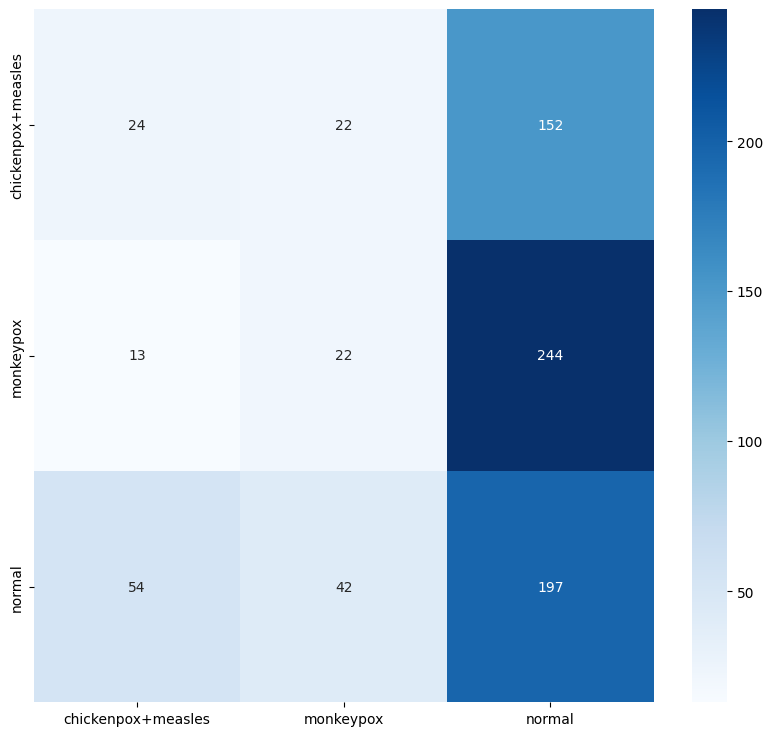

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(array, index = ["chickenpox+measles", "monkeypox", "normal"],
                  columns = ["chickenpox+measles", "monkeypox", "normal"])
plt.figure(figsize = (10,9))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

{'loss': [2.803072690963745, 1.0610477924346924, 1.0030038356781006, 0.8769139051437378, 0.804948627948761, 0.7454453706741333, 0.7833592295646667, 0.7945190668106079, 0.6916256546974182, 0.6535321474075317, 0.633043646812439, 0.5896888375282288, 0.5659079551696777, 0.6146834492683411, 0.6315246224403381, 0.5578001737594604, 0.5771675109863281, 0.5740858912467957, 0.5472690463066101, 0.5856847167015076, 0.6165489554405212, 0.6168842315673828, 0.733402669429779, 0.676825761795044, 0.6586151719093323, 0.5335731506347656, 0.5084766149520874, 0.47168707847595215, 0.44911473989486694, 0.4607047736644745], 'categorical_accuracy': [0.4047619104385376, 0.5259740352630615, 0.5857142806053162, 0.6246753334999084, 0.6688311696052551, 0.6722943782806396, 0.6714285612106323, 0.6584415435791016, 0.6753246784210205, 0.6835497617721558, 0.7021645307540894, 0.695671021938324, 0.7090908885002136, 0.6974025964736938, 0.6904761791229248, 0.7077922224998474, 0.7073593139648438, 0.7030302882194519, 0.710389

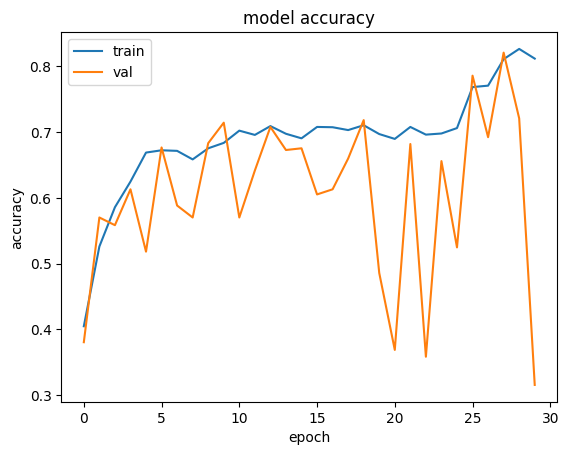

In [ ]:
import matplotlib.pyplot as plt
print(history.history)
print(history.history['categorical_accuracy'])
print(history.history['val_categorical_accuracy'])
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
# plt.plot([0.9730,0.9416,0.9319,0.9611,0.9632,0.9739,0.9769,0.9781,0.9798,0.9816])
# plt.plot([0.9250,0.9610,0.9730,0.9760,0.9690,0.9670,0.9620,0.9680,0.9650,0.9620])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

[2.803072690963745, 1.0610477924346924, 1.0030038356781006, 0.8769139051437378, 0.804948627948761, 0.7454453706741333, 0.7833592295646667, 0.7945190668106079, 0.6916256546974182, 0.6535321474075317, 0.633043646812439, 0.5896888375282288, 0.5659079551696777, 0.6146834492683411, 0.6315246224403381, 0.5578001737594604, 0.5771675109863281, 0.5740858912467957, 0.5472690463066101, 0.5856847167015076, 0.6165489554405212, 0.6168842315673828, 0.733402669429779, 0.676825761795044, 0.6586151719093323, 0.5335731506347656, 0.5084766149520874, 0.47168707847595215, 0.44911473989486694, 0.4607047736644745]
[10446982.0, 57.730899810791016, 28.73150634765625, 1.6243479251861572, 37.12625503540039, 0.9146051406860352, 6.4655351638793945, 12.003057479858398, 0.672355055809021, 0.5547284483909607, 0.6658931374549866, 0.9770671725273132, 0.6771978735923767, 0.6993504762649536, 0.6871271133422852, 0.9960371255874634, 21.892576217651367, 0.7594963312149048, 0.5244291424751282, 15.790534019470215, 1.8510360717

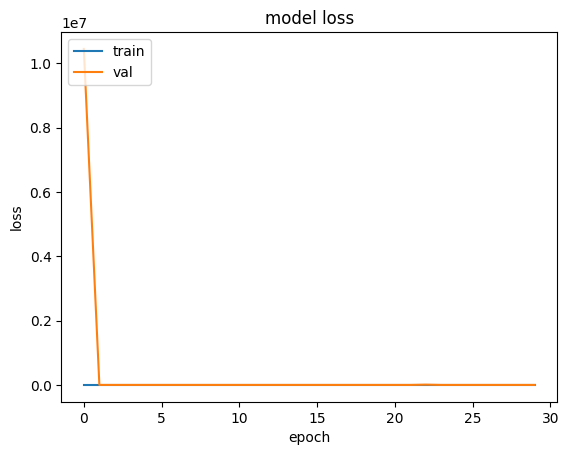

In [ ]:
print(history.history['loss'])
print(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.plot([0.3015,0.1494,0.1164,0.0994,0.0858,0.0766,0.0689,0.0649,0.0588,0.0526])
# plt.plot([0.2164,0.1063,0.0831,0.0733,0.0940,0.1094,0.1479,0.1522,0.1211,0.1249])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()